In [1]:
import csv
import numpy as np
import pandas as pd

from collections import Counter
from matplotlib import pyplot
from scipy import stats
from sklearn.metrics import roc_auc_score
# from tabulate import tabulate


In [2]:
pd.options.display.max_colwidth= 100


In [3]:
dataset = pd.read_csv("data/dataset.csv", index_col=0)
dataset = dataset.reset_index(0)
dataset.head()

,index,animated,cases,grammatical,positions,sentence,template
0,0,False,NDA,True,123,"Es steht fest, dass der Polizist dem Fahrer den Führerschein abnimmt.",0
1,1,False,NAD,True,123,"Es steht fest, dass der Polizist den Fahrer dem Führerschein abnimmt.",0
2,2,False,DNA,True,123,"Es steht fest, dass dem Polizisten der Fahrer den Führerschein abnimmt.",0
3,3,False,DAN,True,123,"Es steht fest, dass dem Polizisten den Fahrer der Führerschein abnimmt.",0
4,4,False,AND,True,123,"Es steht fest, dass den Polizisten der Fahrer dem Führerschein abnimmt.",0


In [4]:
pcibex = pd.read_csv("data/pcibex_df_all_june29.csv")
pcibex.Name = pcibex.Name.astype(str)

/Users/charlotterochereau/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Fillers analyses

In [5]:
grammatical_idx = dataset[dataset['grammatical']==True].index
ungrammatical_idx = dataset[dataset['grammatical']==False].index

In [6]:
fillers = pd.read_csv("data/fillers.csv")

is_exp = pcibex['Type']=="experiment"
is_choice = pcibex['Parameter']=="Choice"
is_filler = pcibex['Index']>9999
is_not_filler = pcibex['Index']<10000


filler_responses = pcibex[is_exp & is_choice & is_filler]
fillers_only = filler_responses.copy()
fillers_only.Value = fillers_only.Value.astype(int)
fillers_only.Index = fillers_only.Index.astype(int)
fillers_only.Name = fillers_only.Name.astype(str)

is_w = (fillers_only["Index"]>999) & (fillers_only["Index"] < 10010)
is_m = (fillers_only["Index"]>1009) & (fillers_only["Index"] < 10015)
is_r = fillers_only["Index"]>10014
all_names = fillers_only.Name.unique()

In [104]:
# Pass/fail test based on fillers
failed = []
passed = []
counter_eval_fail = 0
counter2 = 0

for name in all_names:

    is_pcibex_name = pcibex['Name']==name
    is_name = fillers_only['Name']==name
    r_mean = fillers_only[is_name & is_r].Value.mean()
    w_mean = fillers_only[is_name & is_w].Value.mean()
    m_mean = fillers_only[is_name & is_m].Value.mean()

    #t, p = stats.ttest_ind(fillers_only[is_name & is_r].Value, fillers_only[is_name & is_w].Value, equal_var=False)
    # testing if mean of correct fillers is statistically larger than mean of incorrect fillers
   
    #if (p > 0.05) or (w_mean > r_mean) or (w_mean > m_mean):
    if w_mean > r_mean:
        failed.append(name)
    else:
        passed.append(name)
    
    """
    # filler test
    if (p <= 0.05) and (t > 0):
        passed.append(name)
        filler_test = 'pass'
    else:
        failed.append(name)
        filler_test = 'fail'
    
    
    # checking participant's results on dataset
    
    gram_stc = pcibex[is_answer & pcibex['Index'].isin(grammatical_idx) & is_pcibex_name].Value.astype(int)
    ungram_stc = pcibex[is_answer & pcibex['Index'].isin(ungrammatical_idx) & is_pcibex_name].Value.astype(int)
    gram_mean = gram_stc.mean()
    ungram_mean = ungram_stc.mean()
    t1, p1 = stats.ttest_ind(gram_stc, ungram_stc, equal_var=False)
    
    if (p1 <= 0.05) and (t1 > 0):
        eval_test = "pass"
    else:
        eval_test = "fail"
        counter_eval_fail+=1
    
    if (filler_test == 'fail') and (eval_test == "pass"):
        counter2 += 1
    
    line = f'{name}, fillers:{filler_test}, gram mean = {round(gram_mean,2)}, ungram mean = {round(ungram_mean,2)}, eval:{eval_test}'
    # print(line)
    """

In [8]:
print("mean fillers",round(fillers_only.Value.mean(),2))
print(len(passed), 'passed')
print(len(failed),'failed')
print(len(passed)/(len(passed)+len(failed)), 'passed')
print('participated already',len(passed)+len(failed))

mean fillers 79.3
133 passed
9 failed
0.9366197183098591 passed
participated already 142


In [33]:
print(failed[0])

1663423


In [89]:
print('participant, group, group freq')
for participant in failed:
    failed_group = int(pcibex[pcibex['Name']==participant].Group.unique()[1])
    print(participant, failed_group, 
          pcibex[is_exp & is_choice & is_not_filler & (pcibex['Group']==failed_group)].Name.nunique())

participant, group, group freq
1663423 44 2
1862278 81 5
1309021 81 5
2%2C443%2C107 64 1
1%2C441%2C450 84 1
2%2C534%2C260 47 1
1535212 52 3
2%2C711%2C491 31 1
1%2C444%2C321 83 1


In [84]:
print(pcibex[is_exp & is_choice & is_not_filler & (pcibex['Group']==81)].Name.nunique())

5


In [9]:
# Select responses
is_pass = pcibex["Name"].isin(passed)
is_answer = is_exp & is_choice & is_not_filler & is_pass
# is_answer = is_exp & is_choice & is_not_filler 

"""
pcibex[is_answer]["Group"].unique()
pcibex[is_answer].groupby('Group')['Group'].count()/216
#for duplicated answers: pcibex[is_answer].groupby('Index')['Index'].count() - 3).clip(0).sum()/216
"""
answers_only = pcibex[is_answer].copy()
answers_only.Value = answers_only.Value.astype(int)
answers_only.Index = answers_only.Index.astype(int)
answers_only.Group = answers_only.Group.astype(int)
answers_only.Name = answers_only.Name.astype(str)

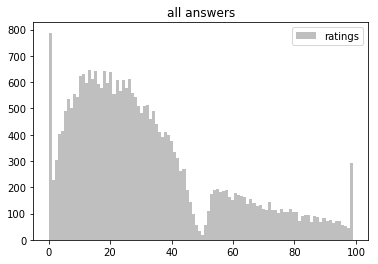

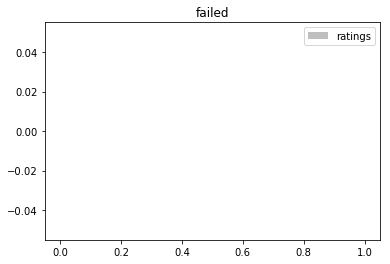

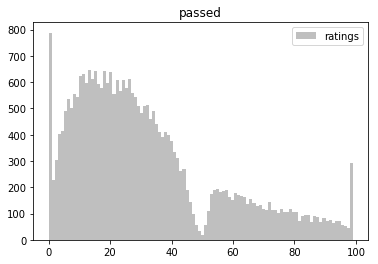

In [10]:
pyplot.hist(answers_only.Value, bins = 100, alpha=0.5, color="grey", label='ratings')
pyplot.legend(loc='upper right', prop={'size': 10})
pyplot.title('all answers')
pyplot.show()

pyplot.hist(answers_only[answers_only['Name'].isin(failed)].Value, bins = 100, alpha=0.5, color="grey", label='ratings')
pyplot.legend(loc='upper right', prop={'size': 10})
pyplot.title('failed')
pyplot.show()

pyplot.hist(answers_only[answers_only['Name'].isin(passed)].Value, bins = 100, alpha=0.5, color="grey", label='ratings')
pyplot.legend(loc='upper right', prop={'size': 10})
pyplot.title('passed')
pyplot.show()

In [11]:
# Normalize results
rater_stats = answers_only.groupby('Name')['Value'].agg(['mean', 'std']).transpose()
answers_only["Normalized Value"] = [(rating - rater_stats[name]["mean"]) / rater_stats[name]["std"]  
                                    for name, rating 
                                    in  zip(answers_only.Name, answers_only.Value)]

In [12]:
### data normalization
answers_summary = answers_only.groupby('Index')['Normalized Value'].agg(["mean", "count","std"])
#answers_summary = answers_only.groupby('Index')['Value'].agg(["mean", "count","std"])

answers_summary = answers_summary.reset_index(0)

data = pd.merge(left=dataset, right=answers_summary, left_on='index', right_on='Index')

In [13]:
pcibex[pcibex['Group']==26].Name.unique()
# group 39: no annotation!

array(['1%2C083%2C617', '1862514'], dtype=object)

In [14]:
pci_dataset = pd.read_csv("data/pcibex2.csv", index_col=0).reset_index('Sentence')
mylist = [idx for idx in pci_dataset[pci_dataset['Group']==39].DatasetIndex if idx < 10000]
print(pci_dataset.Group.unique())

[ 1  2  3  7  8 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 42 45 46 47 48 50 51 52 53 56 57 58 59 61 63
 64 67 68 69 72 73 74 75 76 77 79 80 82 83 84 85 88 89 90 91 93 96 98]


In [15]:
for idx in mylist:
    count_idx = data[data['index']==idx]['count']
    print(count_idx)

876    3
Name: count, dtype: int64
1021    3
Name: count, dtype: int64
1166    3
Name: count, dtype: int64
1311    3
Name: count, dtype: int64
1456    3
Name: count, dtype: int64
1601    3
Name: count, dtype: int64
1746    3
Name: count, dtype: int64
1891    3
Name: count, dtype: int64
2036    3
Name: count, dtype: int64
2181    3
Name: count, dtype: int64
2326    3
Name: count, dtype: int64
2471    3
Name: count, dtype: int64
2616    3
Name: count, dtype: int64
2761    3
Name: count, dtype: int64
2906    3
Name: count, dtype: int64
3051    3
Name: count, dtype: int64
3196    3
Name: count, dtype: int64
3341    3
Name: count, dtype: int64
3486    5
Name: count, dtype: int64
3631    5
Name: count, dtype: int64
3776    5
Name: count, dtype: int64
3921    5
Name: count, dtype: int64
4066    5
Name: count, dtype: int64
4211    5
Name: count, dtype: int64
4320    5
Name: count, dtype: int64
4465    5
Name: count, dtype: int64
4610    5
Name: count, dtype: int64
4755    5
Name: count, dtype:

### Responses analyses

In [16]:
is_gram = data['grammatical']==True
is_ungram = data['grammatical']==False
is_nom = data['cases'].isin(['NNA','NND','NAN','NDN','ANN','DNN'])
is_acc = data['cases'].isin(['AAN','AAD','ANA','ADA','NAA','DAA'])
is_dat = data['cases'].isin(['DDN','DDA','DND','DAD','NDD','ADD'])
is_NDA = data['cases']=='NDA'
is_NAD = data['cases']=='NAD'
is_AND = data['cases']=='AND'
is_ADN = data['cases']=='ADN'
is_DNA = data['cases']=='DNA'
is_DAN = data['cases']=='DAN'
is_animate = data['animated']==True
is_inanimate = data['animated']==False
is_123 = data['positions']==123
is_132 = data['positions']==132
is_213 = data['positions']==213
is_231 = data['positions']==231
is_312 = data['positions']==312
is_321 = data['positions']==321

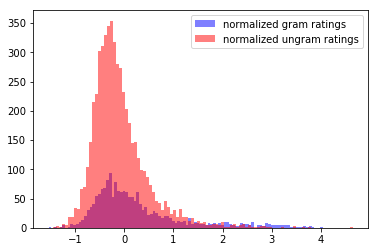

In [17]:
pyplot.hist(data[is_gram]['mean'], bins = 100, alpha=0.5, color="blue", label='normalized gram ratings')
pyplot.hist(data[is_ungram]['mean'], bins = 100, alpha=0.5, color="red", label='normalized ungram ratings')
pyplot.legend(loc='upper right', prop={'size': 10})
pyplot.show()

In [18]:
data.groupby(["grammatical"])["mean"].mean().round(2)#.reset_index()

grammatical
False   -0.10
True     0.29
Name: mean, dtype: float64

In [19]:
print('nom',round(data[is_nom]["mean"].mean(),2),
      'acc',round(data[is_acc]["mean"].mean(),2),
      'dat',round(data[is_dat]["mean"].mean(),2))

nom -0.02 acc -0.11 dat -0.17


In [20]:
data[is_ungram].groupby(["cases"])["mean"].mean().round(2)

cases
AAD   -0.24
AAN   -0.27
ADA   -0.26
ADD   -0.34
ANA   -0.13
ANN   -0.27
DAA   -0.29
DAD   -0.33
DDA   -0.24
DDN   -0.29
DND   -0.13
DNN   -0.16
NAA    0.54
NAN    0.11
NDD    0.34
NDN    0.17
NNA    0.03
NND    0.02
Name: mean, dtype: float64

In [21]:
data[is_gram].groupby(["cases"])["mean"].mean().round(2)#.reset_index()

cases
ADN   -0.19
AND   -0.05
DAN   -0.15
DNA    0.09
NAD    0.81
NDA    1.22
Name: mean, dtype: float64

In [22]:
data[is_gram & is_NDA].groupby(["positions"])["mean"].mean().round(2)

positions
123    2.53
132    0.72
213    2.43
231    0.67
312    0.58
321    0.41
Name: mean, dtype: float64

In [23]:
data[is_gram].groupby(["cases"])["mean"].mean()#.reset_index()

cases
ADN   -0.188203
AND   -0.054823
DAN   -0.154924
DNA    0.093563
NAD    0.809893
NDA    1.220953
Name: mean, dtype: float64

In [24]:
data[is_gram].groupby(["animated"])["mean"].mean()

animated
False    0.231551
True     0.418858
Name: mean, dtype: float64

In [25]:
# AUC per template
aucs = []
nom_aucs = []
acc_aucs = []
dat_aucs = []

for i in range(50):
    is_notnull = data["count"].notnull()
    is_temp = data["template"]==i
    gram_resp = is_temp & is_notnull & is_gram
    ungram_resp = is_temp & is_notnull & is_ungram
    nom_resp = is_temp & is_notnull & is_nom
    acc_resp = is_temp & is_notnull & is_acc
    dat_resp = is_temp & is_notnull & is_dat
   
    labels = [1]*len(data[gram_resp]) + [0]*len(data[ungram_resp])
    nom_labels = [1]*len(data[gram_resp]) + [0]*len(data[nom_resp])
    acc_labels = [1]*len(data[gram_resp]) + [0]*len(data[acc_resp])
    dat_labels = [1]*len(data[gram_resp]) + [0]*len(data[dat_resp])

    scores = pd.concat([data[gram_resp]["mean"], data[ungram_resp]["mean"]])
    nom_scores = pd.concat([data[gram_resp]["mean"], data[nom_resp]["mean"]])
    acc_scores = pd.concat([data[gram_resp]["mean"], data[acc_resp]["mean"]])
    dat_scores = pd.concat([data[gram_resp]["mean"], data[dat_resp]["mean"]])

    auc = roc_auc_score(labels, scores)
    nom_auc = roc_auc_score(nom_labels, nom_scores)
    acc_auc = roc_auc_score(acc_labels, acc_scores)
    dat_auc = roc_auc_score(dat_labels, dat_scores)
    
    aucs.append(auc)
    nom_aucs.append(nom_auc)
    acc_aucs.append(acc_auc)
    dat_aucs.append(dat_auc)  
    
    #print('template ',i,'AUC: %.3f' % auc)
    
print(f"auc over templates: {round(np.mean(aucs),2)}, previous:0.58")
print(f"auc nom over templates: {round(np.mean(nom_aucs),2)}, previous:0.56")
print(f"auc acc over templates: {round(np.mean(acc_aucs),2)}, previous:0.60")
print(f"dat dat over templates: {round(np.mean(dat_aucs),2)}, previous:0.57")

auc over templates: 0.62, previous:0.58
auc nom over templates: 0.57, previous:0.56
auc acc over templates: 0.62, previous:0.60
dat dat over templates: 0.65, previous:0.57


In [26]:
def get_one_letter_diff(word):
    violations = []
    letters = ["A", "D", "N"]
    for letter_1 in letters:
        for letter_2 in letters:
            if letter_1 != letter_2:
                violations.append(word.replace(letter_1, letter_2))                
    return violations   

In [27]:
tmp_template = data['template'] == 0
tmp_pos = data['positions'] == 123
tmp_cases = data['cases'] == 'NDA'
print('NDA', data[tmp_template & tmp_pos & tmp_cases].sentence)
tmp_viol = get_one_letter_diff('NDA')
for viol in tmp_viol:
    print(viol, data[tmp_template & tmp_pos & (data['cases'] == viol)].sentence)

NDA 0    Es steht fest, dass der Polizist dem Fahrer den Führerschein abnimmt.
Name: sentence, dtype: object
NDD 52    Es steht fest, dass der Polizist dem Fahrer dem Führerschein abnimmt.
Name: sentence, dtype: object
NDN 39    Es steht fest, dass der Polizist dem Fahrer der Führerschein abnimmt.
Name: sentence, dtype: object
NAA 46    Es steht fest, dass der Polizist den Fahrer den Führerschein abnimmt.
Name: sentence, dtype: object
NNA 36    Es steht fest, dass der Polizist der Fahrer den Führerschein abnimmt.
Name: sentence, dtype: object
ADA 45    Es steht fest, dass den Polizisten dem Fahrer den Führerschein abnimmt.
Name: sentence, dtype: object
DDA 49    Es steht fest, dass dem Polizisten dem Fahrer den Führerschein abnimmt.
Name: sentence, dtype: object


In [28]:
# 1 vs 6 analysis
for index, row in data.iterrows():
    if row.grammatical == True:
        is_templ = data['template'] == row.template
        is_pos = data['positions'] == row.positions
        violations = get_one_letter_diff(row.cases)

        scores = [row['mean'],*((data[is_templ & is_pos & (data['cases'] == violation)]['mean'])
                             for violation in violations)]

        labels = [1] + [0]*(len(scores)-1)
        auc = roc_auc_score(labels, scores)
        data.loc[index,'1vs6'] = auc
        

In [30]:
gb = data[is_gram].groupby(["cases", "positions"])["1vs6"].mean().round(2).reset_index().pivot(index="cases",
                                                                                 columns="positions",
                                                                                 values="1vs6")
gb.index.name = None
gb.columns.name = "Case\Pos"
print('AUC 1 vs 6')
gb

AUC 1 vs 6


Case\Pos,123,132,213,231,312,321
ADN,0.44,0.50,0.47,0.50,0.66,0.66
AND,0.53,0.55,0.54,0.56,0.70,0.74
DAN,0.46,0.65,0.52,0.68,0.52,0.45
DNA,0.78,0.57,0.75,0.53,0.55,0.53
NAD,0.72,0.92,0.65,0.89,0.67,0.64
NDA,0.95,0.71,0.96,0.74,0.67,0.68


In [33]:
data[data['template']==0]

,index,animated,cases,grammatical,positions,sentence,template,Index,mean,count,std,1vs6
0,0,False,NDA,True,123,"Es steht fest, dass der Polizist dem Fahrer den Führerschein abnimmt.",0,0,3.120045,5,1.314891,1.000000
1,1,False,NAD,True,123,"Es steht fest, dass der Polizist den Fahrer dem Führerschein abnimmt.",0,1,0.137011,3,0.710654,0.666667
2,2,False,DNA,True,123,"Es steht fest, dass dem Polizisten der Fahrer den Führerschein abnimmt.",0,2,0.289313,3,1.344970,1.000000
3,3,False,DAN,True,123,"Es steht fest, dass dem Polizisten den Fahrer der Führerschein abnimmt.",0,3,-0.311226,3,0.392994,0.166667
4,4,False,AND,True,123,"Es steht fest, dass den Polizisten der Fahrer dem Führerschein abnimmt.",0,4,-0.185622,3,0.260201,0.333333
5,5,False,ADN,True,123,"Es steht fest, dass den Polizisten dem Fahrer der Führerschein abnimmt.",0,5,-0.044694,10,0.577103,0.500000
6,6,False,NDA,True,213,"Es steht fest, dass der Fahrer dem Polizisten den Führerschein abnimmt.",0,6,2.813992,3,1.355005,1.000000
7,7,False,NAD,True,213,"Es steht fest, dass der Fahrer den Polizisten dem Führerschein abnimmt.",0,7,-0.089156,5,0.530694,0.500000
8,8,False,DNA,True,213,"Es steht fest, dass dem Fahrer der Polizist den Führerschein abnimmt.",0,8,-0.322159,3,0.879354,0.500000
9,9,False,DAN,True,213,"Es steht fest, dass dem Fahrer den Polizisten der Führerschein abnimmt.",0,9,-0.236932,6,0.390178,0.333333


In [ ]:
groups_to_evaluate = []
for i in range(100):
    if i not in validated_groups:
        groups_to_evaluate.append(i)
print(len(groups_to_evaluate))
groups_to_evaluate.sort()
for idx, stc in enumerate(groups_to_evaluate):
    print(idx, stc)

In [ ]:
with open('data/urls.txt','w') as outfile:
    for i in range(73):
        line = 'https://expt.pcibex.net/ibexexps/charlotte/geev/server.py?withsquare='
        outfile.write(line + str(i) + '\n')

In [ ]:
### writing IDs for validated blocks of sentences
with open('data/pcibex.csv', 'r') as infile, open('data/pcibex2.csv', 'w') as outfile:
    reader = csv.DictReader(infile)
    writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames)
    writer.writeheader()  # For writing header
    for row in reader:
        if row['Group'] not in validated_groups:
            writer.writerow(row)

In [106]:
# generate pass/fail test w/ corresponding participant's ID
counter1 = 0
counter2 = 0
with open('data/participants_june29.txt', 'w') as outfile:
    for name in all_names:
        
        if name in passed:
            line = name.strip() + ',pass'
            counter1 += 1
        else:
            line = name.strip() +',fail'
            counter2 += 1
        outfile.write(line)
        outfile.write('\n')